In [4]:

#  O my body, make of me always a man who questions!

import spacy
import re
import pandas as pd
import numpy as np
import requests
from spacy.matcher import Matcher 

import networkx as nx

import matplotlib.pyplot as plt

from common import *

nlp = spacy.load('en_core_web_sm')

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


# Sentence preparation

In [5]:
book = read_file('data/Strang-Linear Algebra.txt')

In [6]:
def sentence_fits(s):
    """Check if sentence contains only one subject and one object"""
    deps = ''.join([token.dep_ for token in nlp(s)])
    return deps.count('obj') == 1 & deps.count('subj') == 1
    

In [7]:
chapter = list(get_one_chapter_strang(3, book, subsections=False,
                                      split=True, sentence_spliter=lambda ss: nlp(ss).sents))[0]

sentences = list(filter(sentence_fits, chapter))
sentences

['Geometrically, it is a set of coordinate axes.',
 'A further specialization makes the basis just about optimal: The vectors should have length 1.',
 'More than just vectors, subspaces can also be perpendicular.',
 'We will discover, so beautifully and simply that it will be a delight to see, that the fundamental subspaces meet at right angles.',
 '(1, 2, 0) has length',
 'is the length kxk we want: Length in 3D kxk2 =',
 'Length squared kxk2 =',
 'We go back to a2+b2 = c2:',
 'The right-hand side has an extra .2xiyi',
 'This number is sometimes called the scalar product or dot product, and denoted by (x;y) or x .',
 'If xTy < 0, their angle is greater than 90.',
 'only vector orthogonal to itselfis the zero vector.',
 '(2;2;.1) is orthogonal to (.1;2;2).',
 'Both have length',
 'The same is true of every ci.',
 'The only combination of the vs producing zero has all ci = 0',
 'Those are the columns of the identity matrix.',
 'They point along the coordinate axes.',
 'The subspace f0g 

In [8]:
len(sentences)

271

# Sentence selection

## Relations extraction

Extracting entity pairs (object with subject) and relations (chunks that connect object and subject).

In [9]:
def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)

    pattern = [
            {'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}
    ] 

    matcher.add("matching_pattern", None, pattern) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return span.text 

In [10]:
relations = [get_relation(i) for i in sentences]
pd.Series(relations).value_counts()[:25]

is                  60
are                 15
has                 14
is orthogonal        9
have                 5
is in                4
Suppose              4
satisfy              3
be                   3
gives                3
goes to              3
are orthogonal       3
equals               3
called               3
be orthogonal        2
squared              2
be perpendicular     2
is identical         2
is at                2
add to               2
go                   2
comes from           2
denoted by           2
n                    2
A                    2
dtype: int64

In [11]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check if token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

            # check if token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
                    
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.replace('  ', ' ').strip(), ent2.replace('  ', ' ').strip()]


In [12]:
objects = [''] * len(sentences)
subjects = [''] * len(sentences)

for i, s in enumerate(sentences):
    subjects[i], objects[i] = get_entities(s)
    
subjects = np.array(subjects)
objects = np.array(objects)

subjects[:25]

array(['Geometrically it', 'about vectors', 'just subspaces',
       'fundamental subspaces', '1', 'length we', 'Length', 'We',
       'right hand side', 'number', '< angle', 'only vector', '2;2;.1',
       'Both', 'same', 'only combination', 'Those', 'They',
       'subspace f0 g', 'that', 'V', 'W', 'then w', 'line W',
       'Then dimensions'], dtype='<U30')

## Constructing DataFrame for Knowledge Graph

In [13]:
kg_df = pd.DataFrame({'source':subjects, 'target':objects, 'link':relations})
kg_df.head()

,link,source,target
0,is,Geometrically it,coordinate axes
1,have,about vectors,length
2,be perpendicular,just subspaces,just vectors
3,discover,fundamental subspaces,right angles
4,has,1,length


## Knowledge graph of all extracted entity pairs

In [14]:
G = nx.from_pandas_edgelist(kg_df, 'source', 'target', 
                            edge_attr=True, create_using=nx.MultiDiGraph())


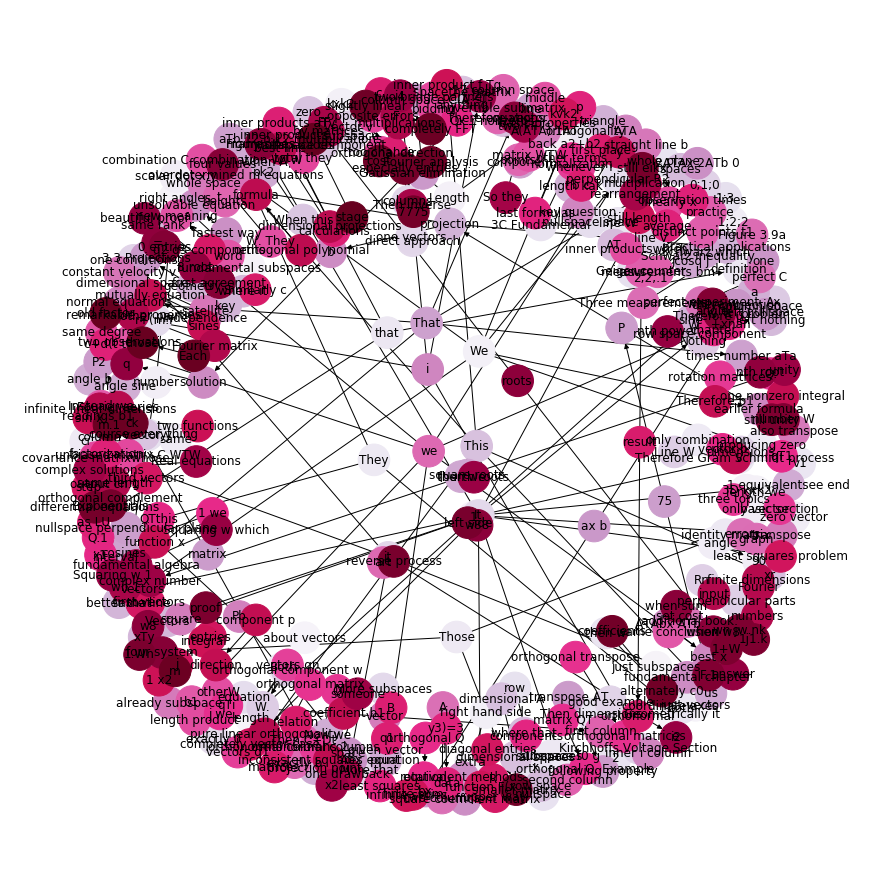

In [15]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=1000, node_color=range(G.number_of_nodes()), 
        pos=pos, cmap=plt.cm.PuRd)
plt.show()


## Example of knowledge graph consisting only of nodes connected by relation `is`

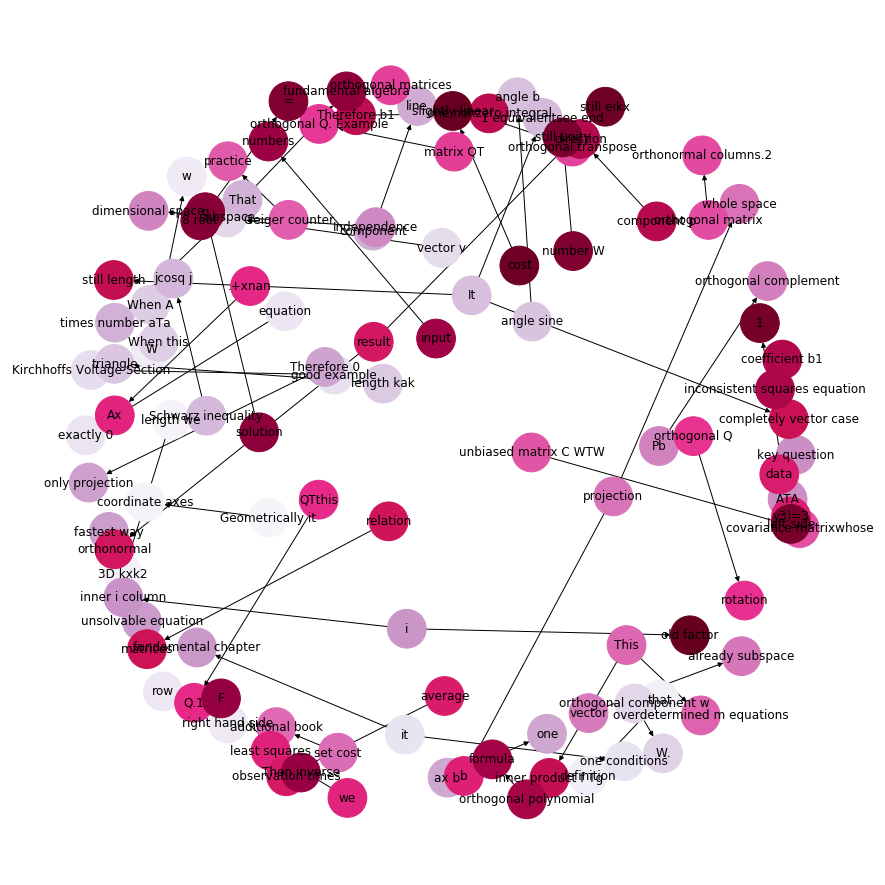

In [16]:
G_smol = nx.from_pandas_edgelist(kg_df[kg_df['link']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_smol, k=.4)
nx.draw(G_smol, with_labels=True, node_color=range(G_smol.number_of_nodes()), 
        node_size=1500, cmap=plt.cm.PuRd, pos=pos)
plt.show()


## Calculating sentences popularity
<br>
<font size="3.5">Popularity is weight of a sentence in a chapter.
Weight is the the sum of outdegrees of the vertices connected by the edge.
Basically, the goal is to find edges evolving around well connected vertices. On the assumption that well connected vertices in the graph are particularly relevant to the topic, this allows us to find the most interesting questions
for a user to answer.</font>

In [17]:
# Adding weights to graph edges for better question selection
popukarity = dict(G.out_degree())
popukarity

{'Geometrically it': 1,
 'coordinate axes': 0,
 'about vectors': 1,
 'length': 0,
 'just subspaces': 1,
 'just vectors': 0,
 'fundamental subspaces': 1,
 'right angles': 0,
 '1': 2,
 'length we': 1,
 '3D kxk2': 0,
 'Length': 2,
 'kxk2': 0,
 'We': 6,
 'back a2+b2': 0,
 'right hand side': 2,
 'extra': 0,
 'number': 2,
 'scalar dot x;y': 0,
 '< angle': 1,
 '90': 0,
 'only vector': 1,
 'zero vector': 0,
 '2;2;.1': 1,
 '.1;2;2': 0,
 'Both': 1,
 'same': 1,
 'ci': 0,
 'only combination': 1,
 'producing zero': 0,
 'Those': 3,
 'identity matrix': 0,
 'They': 3,
 'subspace f0 g': 1,
 'subspaces': 0,
 'that': 3,
 'definition': 0,
 'V': 1,
 'v1': 0,
 'W': 1,
 'w': 1,
 'then w': 1,
 'both': 0,
 'line W': 1,
 'whole plane': 0,
 'Then dimensions': 1,
 '2': 0,
 '3C Fundamental': 1,
 'orthogonality': 0,
 'x': 2,
 'nullspace': 1,
 'row': 1,
 'vector y': 1,
 'column': 0,
 'rows': 1,
 '1;3': 0,
 'nullspace space': 1,
 'perpendicular R2': 0,
 'equation': 1,
 'exactly 0': 0,
 'other pair': 1,
 'r+(m.r': 0,


In [18]:
for u,v,d in G.edges(data=True):
    d['weight'] = popukarity[u] + popukarity[v]  # adding outdegres of two nodes connected by edge


In [19]:
# getting sorted indexes of best sentences

indexes = np.flip(np.argsort(np.array([x[2]['weight'] for x in G.edges(data=True)])))

# Quiz Construction

In [20]:
sentences = np.array(sentences)
top_sentences = sentences[indexes]
top_sentences[:10]

array(['The row space component goes to the column space:',
       'The nullspace component goes to zero:',
       'A where it is invertible, and has the same rank r.',
       'On those r-dimensional spaces A is invertible.',
       'AT moves the spaces correctly, but not the\x0c 3.1 Orthogonal Vectors and Subspaces 167 individual vectors.',
       'A where that is possible: A+Ax = x for x in the row space.',
       'On the left nullspace, nothing can be done: A+y =',
       'Vectors with xTy = 0 are orthogonal.',
       'Now we allow inner products that are not zero, and angles that are not right angles.',
       'This puts xr .x0r'], dtype='<U130')

In [22]:
from quiz_generation import create_quiz


n = 10

quiz_sentences = top_sentences[:n]
subj_keys = subjects[indexes][:n]
obj_keys = objects[indexes][:n]
distractors = []

quiz_questions = []
print(create_quiz(list(zip(quiz_sentences, obj_keys)), correct_answer=True))

This is a LinearUp - automatically generated quiz


The row space component goes to the __________:
(a) column space	
(Answer:column space)

The nullspace component goes to __________:
(a) zero	
(Answer:zero)

A where it is invertible, and has the __________
(a) same rank r.	
(Answer:same rank r.)

On those r-__________ A is invertible.
(a) dimensional spaces	
(Answer:dimensional spaces)

AT moves the __________ correctly, but not the 3.1 Orthogonal Vectors and Sub__________ 167 individual vectors.
(a) spaces	
(Answer:spaces)

A where that is possible: A+Ax = x for x in the __________.
(a) row space	
(Answer:row space)

On the __________, nothing can be done: A+y =
(a) left nullspace	
(Answer:left nullspace)

Vectors with __________ = 0 are orthogonal.
(a) xTy	
(Answer:xTy)

Now we allow __________ that are not zero, and angles that are not right angles.
(a) inner products	
(Answer:inner products)

This puts __________ .x0r
(a) xr	
(Answer:xr)


